<a href="https://colab.research.google.com/github/bokutachi256/gisday2019/blob/master/3_%E6%8E%A5%E5%B3%B0%E9%9D%A2%E3%81%A8%E9%99%B0%E5%BD%B1%E5%9B%B3%E3%81%AE%E8%A8%88%E7%AE%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 接峰面と陰影図の計算


* GIS Day in 東京 2019 Eコース
* Pythonを用いたDEM処理
* 首都大学東京 都市環境学部 地理環境学科 中山大地
* 2019年12月21日 首都大学東京 南大沢キャンパス
* [github repository: www.github.com/bokutachi256/gisday2019](https://www.github.com/bokutachi256/gisday2019)


# はじめに

接峰面は窓領域を移動させて計算しますが，
Pythonでは配列をループで回す処理が遅いために工夫が必要です．
この章では画像処理ライブラリのOpenCVを使ってカーネルの畳み込み演算をすることにより高速に処理します．
陰影図は`gdal`を使って作成します．


# 計算の準備

## ライブラリのインストール

標準ではGoogle Colaboratoryに用意されていないライブラリ（`pysheds`）を，マジックコマンドでpipを使ってインストールします．
マジックコマンドはGoogle Colaboratory上でUNIXのコマンドを実行する方法です．


In [ ]:
#%pip install pysheds

## ライブラリのインポート


このプログラムでは，以下のライブラリを使用します．

* `cv2`：画像処理ライブラリOpenCV
* `numpy`: 多次元配列計算のライブラリ．
* `matplotlib.pyplot`: グラフ作成・データ可視化ライブラリ．
* `matplotlib.colors`: カラーライブラリ．
* `tqdm`：プログレスバーを表示するライブラリ
* `pysheds`：流路網・流域処理のライブラリ．GeoTiffの読み書きにも使用．
* `osgeo`: 地理データ処理ライブラリ．陰影図の計算，GeoTiffの読み書きに使用．
* `google.colab`: Google Colaboratory用ライブラリ．google driveのマウントに使用．


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from pysheds.grid import Grid
from pysheds.view import Raster, ViewFinder
from osgeo import gdal, gdalconst, gdal_array, osr
#from google.colab import drive

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## google driveのマウント



`drive.mount`を使ってGoogle DriveをGoogle Colaboratoryにマウントします．
`drive.mount`の引数はGoogle Colaboratory内のマウントポイントです．
このマウントポイントで示されたディレクトリにGoogle Driveのルートディレクトリ（マイドライブ）が接続されます．

`drive.mount`が実行されると，どのGoogleアカウントで接続するか聞かれます．
適切なアカウントを指定してアクセス権を与えます．
その後認証コードが発行されますので，それをコピーしてテキストボックスにペーストしてください．
これでGoogle Driveがマウントされます．

マイドライブの中に作業用のディレクトリ`gisday2019`を作成してください．
この作業用ディレクトリへのフルパスは`/drive/My Drive/gisday2019`になります．
これを変数`base_dir`に格納しておきます．

In [2]:
#drive.mount('/content/drive')
base_dir = "./"

## GeoTiff形式のDEMを読み込む


Pyshedsの`Grid`オブジェクトを使ってDEMのGeoTiffを読み込みます．
`Grid.from_raster`を使うと
インスタンスの生成とGeoTiffの読み込みが同時にできます．
第一引数は読み込むGeoTiffのファイル名，第二引数はインスタンス内での名前です．ここでは`dem`にしました．
以降は`grid.dem`で標高値にアクセスできます．

In [3]:
grid = Grid()
dem = grid.read_raster(base_dir + 'tanzawa_dem_JGD2011_reprojected.tif')

# 接峰面の計算

## 接峰面の計算アルゴリズム


接峰面はDEMに窓領域をかけ，領域内の平均値を中心メッシュに入れていきます．
これをDEM全体で行った後，元の標高DEMと比較をします．
平均値よりも元の標高の方が大きい場合は元の標高を残し，
平均値の方が大きい場合は平均値を残します．
このようにして新しいDEMを作成します．
この計算を繰り返します．

これにより，窓領域内の標高が高い部分が残り，
標高の低い部分が埋められたDEMが取得できます．

$m \times n$メッシュのDEMを考えます．
$z$は各メッシュにおける標高を表します．

$$
DEM =
  \begin{bmatrix}
    z_{11} & z_{21} & z_{31} & \ldots & z_{m1}\\
    z_{12} & z_{22} & z_{32} & \ldots & z_{m2}\\
    z_{13} & z_{23} & z_{33} & \ldots & z_{m3}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    z_{1n} & z_{2n} & z_{3n} & \ldots & z_{mn}
 \end{bmatrix}\\
$$

任意のメッシュ$(i, j)$における$3\times3$メッシュの平均標高を$ｍ_{ij}$とします．
たたみ込み演算によりDEM全体で平均を求め，配列$MEAN$とします．
$MEAN$は以下のようになります．

$$
MEAN =
  \begin{bmatrix}
    0 & 0       & 0       & 0      & 0\\
    0 & m_{22} & m_{32} & \ldots & 0\\
    0 & m_{23} & m_{33} & \ldots & 0\\
    0 & m_{24} & m_{34} & \ldots & 0\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    0 & 0 & 0 & \ldots & 0
  \end{bmatrix}\\
$$

次に$DEM$と$MEAN$を比較し，値の大きい方を新しい標高配列$DEM_{new}$とします．

$$
DEM_{new} = \left\{
\begin{array}{ll}
  DEM & (DEM \geq MEAN)\\
  MEAN & (DEM \lt MEAN)
\end{array}
\right.
$$


## 実際の計算

まずDEMの前処理を行います．
読み込んだDEMはデータなしを示す値として-9999が入っています．
また，一部には負の標高値が入っているので，
これらの値を`np.where`を使用して0に置き換えます．

`np.where`の第一引数は置き換えの条件式，
第二引数は条件式が真だった場合の値，
第三引数は条件式が偽だった場合の値です．

条件式は標高値が負であるかどうかなので，`grid.dem < 0`になります．
負の場合は0なので第二引数は`0`，
偽の場合は標高値をそのまま残すので第三引数を`grid.dem`とします．
置き換えた配列を`dem`に格納します．


In [4]:
dem = Raster(np.where(dem < 0, 0, dem), viewfinder = dem.viewfinder)
#dem = np.where(dem < 0, 0, dem)

## OpenCVを用いた畳み込み演算

次に畳み込み演算に用いるカーネル関数を作成します．

カーネル関数のサイズは結果に大きく影響します．
サイズが大きいほど平均を取る範囲が平奥なるため，
接峰面はなめらかになります．
また，畳み込み演算で中心メッシュに平均値を入れることから，
カーネルの一辺は奇数のほうが適しています．
ここでは一辺の大きさを`11`メッシュにしました．
変数`kernel_size`を`11`にします．

カーネル関数は`kernel`に格納します．
`np.ones`を使ってカーネル行列をすべて1で埋めます．
`np.ones`の第一引数はカーネルの大きさで，タプルで上下左右サイズ共に`kernel_size`とします．
第二引数はカーネルの型です．
32bit浮動小数点`np.float32`にします．

畳み込み演算はカーネル関数の値に行列の値を掛けたものを合計して中心セルに代入するため，
このままではカーネルの合計値が中心セルに代入されます．
カーネル内のメッシュ数（$11\times 11$），
すなわち`kernel_size * kernel_size`で割って平均を求めるカーネルにします．

In [5]:
kernel_size = 11
kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)

畳み込み演算の結果を格納する配列`dst`を作成します．
初期値は負の標高値を0で置き換えた`dem`にします．

In [6]:
summit = dem

`cv2.filer2D`を用いて畳み込み演算を行います．

```python
summit = cv2.filter2D(dst, -1, kernel)
```

`cv2.filter2D`の第一引数は畳み込み演算を行う配列で`dst`，
第二引数は出力値の次元で元画像と同じ場合は-1，
第三引数はカーネル関数`kernel`です．
畳み込み演算の結果を`dst`に代入します．

次に畳み込み演算と元の標高値との比較を取り，
値の大きい方を新しい配列に代入します．
これには配列の要素ごとに最大値を返す`np.maximum`を使います．

```python
summit = np.maximum(summit, dem)
```

以上の畳み込み演算と比較を`for`ループを使用して繰り返します．
ループ回数が多いほど平滑化された接峰面になります．

```python
for i in range(50)
  summit = cv2.filter2D(summit, -1, kernel) 
  summit = np.maximum(summit, dem) 
```

下の例では`for`ループに`tqdm`を使ってプログレスバーを表示するようにしています．


In [7]:
for i in tqdm(range(50)):
  summit = cv2.filter2D(summit, -1, kernel) 
  summit = np.maximum(summit, dem) 

100%|██████████| 50/50 [00:02<00:00, 18.84it/s]


## 接峰面の図化

`plt.imshow`を使って接峰面を図化します．

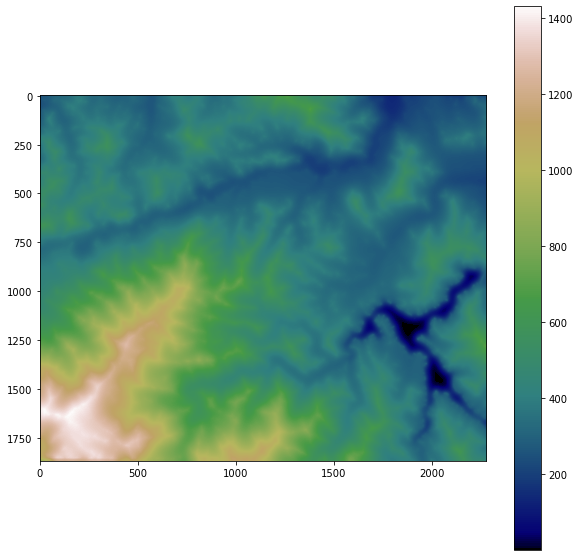

In [8]:
plt.figure(figsize = (10, 10))
im = plt.imshow(summit, cmap = 'gist_earth') 
plt.colorbar(im)
plt.show()

一部分を拡大します．

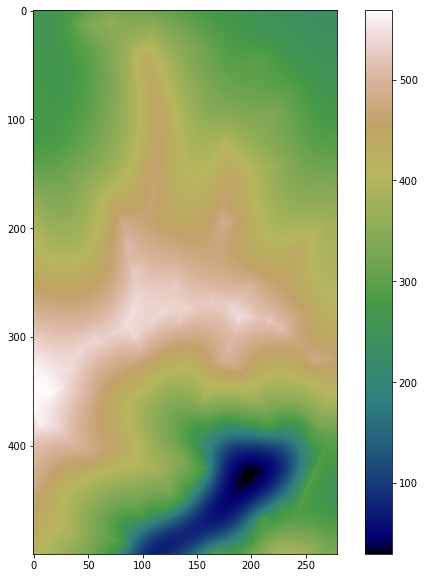

In [9]:
plt.figure(figsize=(10,10))
im = plt.imshow(summit[500:1000, 2000:2500], cmap = 'gist_earth') 
plt.colorbar(im)
plt.show()

## 接峰面をGeoTiffで保存する

`add_gridded_data`を使って接峰面`dst`を`grid`に追加します．
その後`miyake_summit_JGD2011_zone9.tif`として保存します．

In [10]:
grid.to_raster(summit, base_dir + 'tanzawa_summit_JGD2011_reprojected.tif', target_view = summit.viewfinder, blockxsize = 16, blockysize = 16)

# 陰影図の作成

陰影図は`gdal`を使って簡単に計算できます．

## DEMの読み込みと陰影図の計算

`gdal.Open`を使ってDEMのGeoTiffを開きます．

In [ ]:
src = gdal.Open(base_dir + '/GSI-DEM/miyake_dem_JGD2011_zone9.tif')

`gdal.DEMProcessing`を使って陰影の計算をします．
`gdal.DEMProcessing`の第一引数は結果の出力先です．
今回はオブジェクト`hillshade`に出力しまうのでヌル文字にします．
第二引数は元データとなるオブジェクトです．
DEMのGeoTiffを`src`としてインスタンス化してありますので
`src`とします．
第三引数は計算モードです．陰影図の場合は`hillshade`にします．
第四引数は結果の出力形式です．
今回はオブジェクトを出力先にしているため`MEM`にします．
引数`zFactor`は標高の強調倍率です．
標高と水平方向の単位がともにメートルなので値を`1`にします．
引数`azimuth`は太陽方位です．
北西から光が当たった陰影が最も自然に見えるので`300`にしました．


In [ ]:
hillshade = gdal.DEMProcessing('', src, 'hillshade', format = 'MEM', zFactor = 1, azimuth = 300)

`ReadAsArray()`プロパティを使って陰影図の配列を取り出し，
配列`dem_shade`に格納します


In [ ]:
dem_shade = hillshade.ReadAsArray()

## 陰影図の図化

`plt.imshow`を使って図化します．

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(dem_shade, cmap = 'gray') 
plt.colorbar(im)
plt.show()

一部分を拡大してみます．

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(dem_shade[500:1000, 2000:2500], cmap = 'gray') 
plt.colorbar(im)
plt.show()

## 陰影図をGeoTiffで保存する

`add_gridded_data`を使って陰影配列`dem_shade`をオブジェクト`grid`に追加しまし，`to_raster`でGeoTiffに書き出します．

In [ ]:
grid.add_gridded_data(data = dem_shade, data_name = 'dem_shade', affine = grid.affine, crs = grid.crs, nodata = 0)
grid.to_raster('dem_shade', base_dir + 'miyake_dem_shade_JGD2011_zone9.tif', blockxsize = 16, blockysize = 16, view = False)